# 파생변수 생성

* 가격 변수를 이용한 파생 변수 생성 
    * 추세와 계절성으로 인해 shift현상이 발생하므로 가격 변수의 잔차를 이용하여 파생변수 생성
    * extrapolate_trend를 이용하여 잔차의 nan값을 없앤 값과 nan을 잔차의 평균으로 대체한 값 각각 적용
        * 추세 끝점의 nan값을 최소 제곱 추정 값으로 대체하고 가장 가까운 npoint시점을 고려한 회귀로 대체함.


### 환경설정

In [1]:
import pandas as pd
import os
import numpy as np
import warnings

from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

os.chdir(r'C:\Users\a0105\Desktop\DSC\ddd\preprocessing')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

### 전체 데이터셋 불러오기 

In [2]:
data = pd.read_pickle('전체_data.pkl')

In [3]:
data2 = data.copy()

In [4]:
data

,주간날짜,미국소_생산량(가격화한값),수출 (100만달러),수입 (100만달러),소비자물가지수 (2010=100),수입소고기_총량,평균기온,최저기온,최고기온,평균지면온도,최소상대습도(%),평균상대습도(%),한우 평균경매 금액_주간평균,돼지 탕박 경매 금액_주간평균,한우 경매 예상 두수_주간평균,명절유무,번식우,번식우_no
0,2013-01-06,226130.0,559632,515586,98,28623,-0.3,-4.6,5.4,-2.5,16.0,29.6,13875.600000,3044.800000,0.0,0,1580,916
1,2013-01-13,226130.0,559632,515586,98,28623,1.4,-2.2,6.1,0.0,30.0,49.6,13213.333333,2984.000000,0.0,0,1580,916
2,2013-01-20,226130.0,559632,515586,98,28623,1.5,-2.2,2.7,0.1,40.0,64.9,12588.833333,2904.000000,0.0,0,1580,916
3,2013-01-27,226130.0,559632,515586,98,28623,3.8,-0.9,9.3,0.4,40.0,63.0,12323.833333,2959.666667,0.0,1,1580,916
4,2013-02-03,187340.0,559632,515586,98,18241,1.5,-1.9,4.5,0.8,22.0,48.4,12325.166667,2862.833333,0.0,1,1580,916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,2018-08-19,242960.0,604860,535202,104,42590,25.1,21.3,27.9,26.2,54.0,72.4,16835.000000,5305.000000,108.5,0,1758,904
294,2018-08-26,242960.0,604860,535202,104,42590,23.2,20.9,27.2,24.5,54.0,77.4,17555.000000,5207.500000,250.0,0,1758,904
295,2018-09-02,215750.0,604860,535202,104,34151,22.4,19.6,25.9,24.4,40.0,60.1,18369.000000,5548.000000,443.0,0,1758,904
296,2018-09-09,215750.0,604860,535202,104,34151,19.4,16.0,23.3,22.1,62.0,77.3,18757.000000,5754.000000,449.0,1,1758,904


In [5]:
data2.head(3)

,주간날짜,미국소_생산량(가격화한값),수출 (100만달러),수입 (100만달러),소비자물가지수 (2010=100),수입소고기_총량,평균기온,최저기온,최고기온,평균지면온도,최소상대습도(%),평균상대습도(%),한우 평균경매 금액_주간평균,돼지 탕박 경매 금액_주간평균,한우 경매 예상 두수_주간평균,명절유무,번식우,번식우_no
0,2013-01-06,226130.0,559632,515586,98,28623,-0.3,-4.6,5.4,-2.5,16.0,29.6,13875.600000,3044.8,0.0,0,1580,916
1,2013-01-13,226130.0,559632,515586,98,28623,1.4,-2.2,6.1,0.0,30.0,49.6,13213.333333,2984.0,0.0,0,1580,916
2,2013-01-20,226130.0,559632,515586,98,28623,1.5,-2.2,2.7,0.1,40.0,64.9,12588.833333,2904.0,0.0,0,1580,916


### 가격 관련 파생변수 생성
한우 평균경매 금액_주간평균 가격을 이용하여 파생변수 생성

In [6]:
warnings.filterwarnings(action='ignore')

data['y_sd'] = ''
data['y_before'] = ''

for i in range(1,len(data['한우 평균경매 금액_주간평균'])):
    data['y_sd'][i] = data['한우 평균경매 금액_주간평균'][i-1]-np.mean(data['한우 평균경매 금액_주간평균'])
    data['y_before'][i] = data['한우 평균경매 금액_주간평균'][i-1]

In [7]:
data = data.iloc[1:,]

In [8]:
data.isnull().sum()

주간날짜                  0
미국소_생산량(가격화한값)        0
수출 (100만달러)           0
수입 (100만달러)           0
소비자물가지수 (2010=100)    0
수입소고기_총량              0
평균기온                  0
최저기온                  0
최고기온                  0
평균지면온도                0
최소상대습도(%)             0
평균상대습도(%)             0
한우 평균경매 금액_주간평균       0
돼지 탕박 경매 금액_주간평균      0
한우 경매 예상 두수_주간평균      0
명절유무                  0
번식우                   0
번식우_no                0
y_sd                  0
y_before              0
dtype: int64

In [9]:
# 변수명 추출
data_names = data.drop(['주간날짜','한우 평균경매 금액_주간평균'],axis=1).columns
data_names = [list(i) for i in data_names]
features = [''.join(i) for i in data_names]
features

['미국소_생산량(가격화한값)',
 '수출 (100만달러)',
 '수입 (100만달러)',
 '소비자물가지수 (2010=100)',
 '수입소고기_총량',
 '평균기온',
 '최저기온',
 '최고기온',
 '평균지면온도',
 '최소상대습도(%)',
 '평균상대습도(%)',
 '돼지 탕박 경매 금액_주간평균',
 '한우 경매 예상 두수_주간평균',
 '명절유무',
 '번식우',
 '번식우_no',
 'y_sd',
 'y_before']

### scaling
scaler 종류
* StandardScaler: 평균과 표준편차 사용
    * 평균을 제거하고 데이터를 단위 분산으로 조정하나 이상치가 있다면 평균과 표준편차에 영향을 미쳐 변환된 데이터의 확산은 매우 달라짐.
    * 이상치가 있는 경우 균형 잡힌 척도 보장 못함.
* MinMaxScaler: 최대, 최소값이 각각 1,0이 되도록 함.
    * 이상치가 있는 경우 변환된 값이 매우 좁은 범위로 압축될 수 있음.(이상치에 민감)
* RobustScaler: 중앙값과 IQR사용하여 이상치의 영향을 최소화
    * 이상치의 영향을 최소화 
* MaxAbsScaler: 최대 절대값과 0이 각각 1, 0이 되도록 함.
    * 절대값이 0~1 사이로 매핑한다는 것은 값을 -1에서 1사이로 재조정한다는 것으로 이상치에 민감할 수 있음.
    

In [10]:
# minmax scaler적용 
minmax_scaler = preprocessing.MinMaxScaler()
np_scaled_data = minmax_scaler.fit_transform(data[features])
scaled_data = data.copy()

scaled_data[features] = np_scaled_data

In [11]:
scaled_data.isnull().sum()

주간날짜                  0
미국소_생산량(가격화한값)        0
수출 (100만달러)           0
수입 (100만달러)           0
소비자물가지수 (2010=100)    0
수입소고기_총량              0
평균기온                  0
최저기온                  0
최고기온                  0
평균지면온도                0
최소상대습도(%)             0
평균상대습도(%)             0
한우 평균경매 금액_주간평균       0
돼지 탕박 경매 금액_주간평균      0
한우 경매 예상 두수_주간평균      0
명절유무                  0
번식우                   0
번식우_no                0
y_sd                  0
y_before              0
dtype: int64

In [12]:
split_date = '2018-01-08'   # [208]번째부터 test (70% 추출한 것)

train = scaled_data[scaled_data['주간날짜'] <= split_date].copy()
test = scaled_data[scaled_data['주간날짜'] > split_date].copy()

In [13]:
scaled_data.isnull().sum()

주간날짜                  0
미국소_생산량(가격화한값)        0
수출 (100만달러)           0
수입 (100만달러)           0
소비자물가지수 (2010=100)    0
수입소고기_총량              0
평균기온                  0
최저기온                  0
최고기온                  0
평균지면온도                0
최소상대습도(%)             0
평균상대습도(%)             0
한우 평균경매 금액_주간평균       0
돼지 탕박 경매 금액_주간평균      0
한우 경매 예상 두수_주간평균      0
명절유무                  0
번식우                   0
번식우_no                0
y_sd                  0
y_before              0
dtype: int64

In [14]:
train_x = train[features]
train_y = train['한우 평균경매 금액_주간평균']

In [15]:
train_x

,미국소_생산량(가격화한값),수출 (100만달러),수입 (100만달러),소비자물가지수 (2010=100),수입소고기_총량,평균기온,최저기온,최고기온,평균지면온도,최소상대습도(%),평균상대습도(%),돼지 탕박 경매 금액_주간평균,한우 경매 예상 두수_주간평균,명절유무,번식우,번식우_no,y_sd,y_before
1,0.745578,0.586710,0.847949,0.000000,0.475438,0.222506,0.240695,0.180822,0.067797,0.263889,0.369208,0.476982,0.000000,0.0,0.481050,0.297778,0.336184,0.336184
2,0.745578,0.586710,0.847949,0.000000,0.475438,0.225064,0.240695,0.087671,0.070218,0.402778,0.597907,0.464194,0.000000,0.0,0.481050,0.297778,0.261078,0.261078
3,0.745578,0.586710,0.847949,0.000000,0.475438,0.283887,0.272953,0.268493,0.077482,0.402778,0.569507,0.473092,0.000000,1.0,0.481050,0.297778,0.190255,0.190255
4,0.159184,0.586710,0.847949,0.000000,0.085518,0.225064,0.248139,0.136986,0.087167,0.152778,0.351271,0.457614,0.000000,1.0,0.481050,0.297778,0.160202,0.160202
5,0.159184,0.586710,0.847949,0.000000,0.085518,0.199488,0.200993,0.147945,0.077482,0.138889,0.185351,0.337116,0.000000,0.0,0.481050,0.297778,0.160354,0.160354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,0.574906,0.715207,0.560310,0.666667,0.550402,0.140665,0.141439,0.090411,0.053269,0.041667,0.037369,0.690457,0.088243,0.0,0.778426,0.131111,0.745515,0.745515
258,0.574906,0.715207,0.560310,0.666667,0.550402,0.235294,0.205955,0.213699,0.121065,0.111111,0.144993,0.345748,0.105671,0.0,0.778426,0.131111,0.626721,0.626721
259,0.574906,0.715207,0.560310,0.666667,0.550402,0.204604,0.253102,0.175342,0.092010,0.222222,0.207773,0.673434,0.422130,0.0,0.778426,0.131111,0.335719,0.335719
260,0.574906,0.715207,0.560310,0.666667,0.550402,0.232737,0.255583,0.194521,0.106538,0.055556,0.068759,0.591113,0.197510,0.0,0.778426,0.131111,0.715008,0.715008


In [16]:
test_x = test[features]
test_y = test['한우 평균경매 금액_주간평균']

In [17]:
test_x.head(5)

,미국소_생산량(가격화한값),수출 (100만달러),수입 (100만달러),소비자물가지수 (2010=100),수입소고기_총량,평균기온,최저기온,최고기온,평균지면온도,최소상대습도(%),평균상대습도(%),돼지 탕박 경매 금액_주간평균,한우 경매 예상 두수_주간평균,명절유무,번식우,번식우_no,y_sd,y_before
262,0.772336,1.0,1.0,1.0,0.569669,0.335038,0.384615,0.265753,0.157385,0.138889,0.167414,0.324568,0.184509,0.0,0.737609,0.0,0.722266,0.722266
263,0.772336,1.0,1.0,1.0,0.569669,0.000000,0.000000,0.000000,0.000000,0.041667,0.023916,0.651535,0.433195,0.0,0.737609,0.0,0.659836,0.659836
264,0.772336,1.0,1.0,1.0,0.569669,0.150895,0.161290,0.104110,0.055690,0.055556,0.106129,0.704444,0.417151,0.0,0.737609,0.0,0.661820,0.661820
265,0.326228,1.0,1.0,1.0,0.413693,0.069054,0.079404,0.060274,0.012107,0.027778,0.013453,0.722267,0.175104,1.0,0.737609,0.0,0.677017,0.677017
266,0.326228,1.0,1.0,1.0,0.413693,0.199488,0.156328,0.131507,0.145278,0.069444,0.032885,0.615569,0.216874,1.0,0.737609,0.0,0.754020,0.754020


In [18]:
test_y.head(5)

262    16729.5
263    16747.0
264    16881.0
265    17560.0
266    16960.0
Name: 한우 평균경매 금액_주간평균, dtype: float64

### 모델 적용

In [19]:
regressor=MLPRegressor(hidden_layer_sizes=[128, 64, 32], max_iter=500, alpha=0.05, batch_size=10)
regressor.fit(train_x,train_y)

pred = regressor.predict(test_x)
pred

test['pred'] = pred

### 시각화

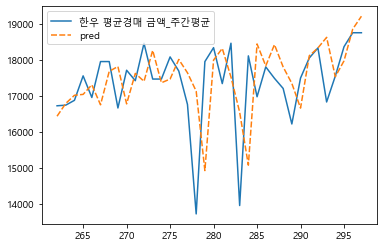

In [20]:
plt.figsize = (15,10)
sns.lineplot(data = test[['한우 평균경매 금액_주간평균','pred']])

예측된 값이 실제 값 따라 shift된 현상 즉 예측된 값이 실제 값을 따라 움직이는 문제점이 발생함. 이는 시계열 데이터에 강한 트렌드와 계절성이 포함되어 있어 결론적으로 학습이 제대로 되지 못한 것임. 이 문제를 해결하기 위해 **가격 변수에 관한 모든 파생변수는 잔차 값을 이용**

---

### 원본 전체 데이터 train, test data set 분리

In [21]:
data = data2.copy()

In [22]:
df = data[['주간날짜','한우 평균경매 금액_주간평균']].set_index('주간날짜')

In [23]:
split_date = '2018-01-07'

train = df[df.index <= split_date].copy()
test = df[df.index > split_date].copy()

### 분해법을 이용하여 잔차 추출

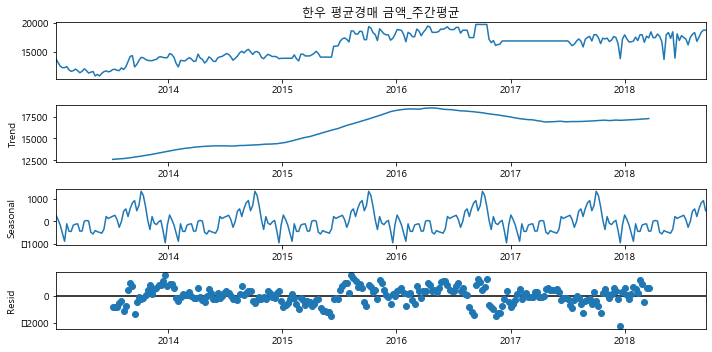

In [24]:
result_add_han = seasonal_decompose(df['한우 평균경매 금액_주간평균'], model='additive')

plt.rcParams['figure.figsize'] = [10, 5]

result_add_han.plot()

plt.show()


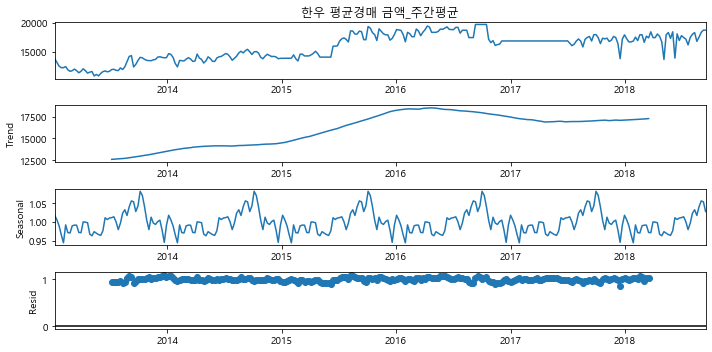

In [25]:
result_mul_han = seasonal_decompose(df['한우 평균경매 금액_주간평균'], model='multiple')

plt.rcParams['figure.figsize'] = [10, 5]

result_mul_han.plot()

plt.show()

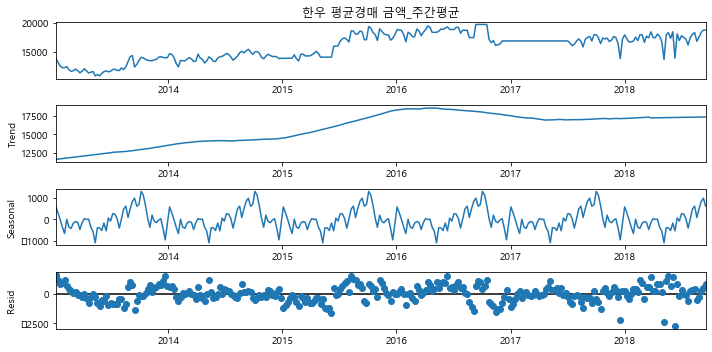

In [26]:
# 1년에 52개 주
# extrapolate_trend: 추세 끝점의 nan값을 최소 제곱 추정 값으로 대체하고 가장 가까운 npoint시점을 고려한 회귀로 대체함.
result_add_han_52 = seasonal_decompose(df['한우 평균경매 금액_주간평균'], model='additive',extrapolate_trend=52)

plt.rcParams['figure.figsize'] = [10, 5]

result_add_han_52.plot()

plt.show()

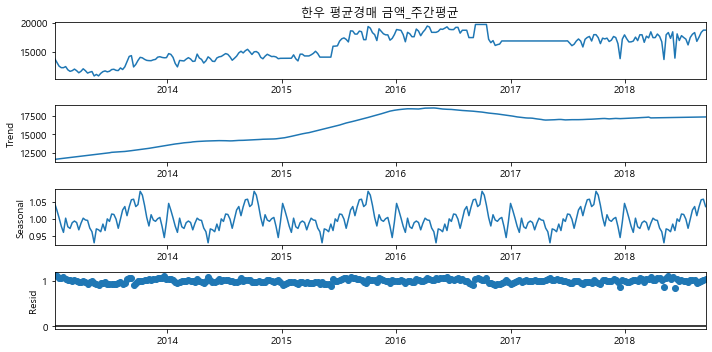

In [27]:
# 1년에 52개 주
result_mul_han_52 = seasonal_decompose(df['한우 평균경매 금액_주간평균'], model='multiple',extrapolate_trend=52)

plt.rcParams['figure.figsize'] = [10, 5]

result_mul_han_52.plot()

plt.show()

In [29]:
result_mul_han_52.resid

주간날짜
2013-01-06    1.137122
2013-01-13    1.100806
2013-01-20    1.069371
2013-01-27    1.069756
2013-02-03    1.087037
                ...   
2018-08-19    0.964366
2018-08-26    0.979869
2018-09-02    1.004748
2018-09-09    1.024114
2018-09-16    1.045282
Name: resid, Length: 298, dtype: float64

### 잔차의 자기상관성 확인

잔차들 간의 상관성이 있으면 예측하는데 사용 가능 

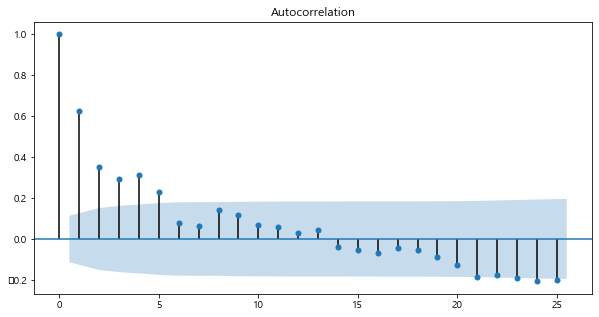

In [196]:
sm.graphics.tsa.plot_acf(result_mul_han.resid.fillna(np.nanmean(result_mul_han.resid)))
plt.show()

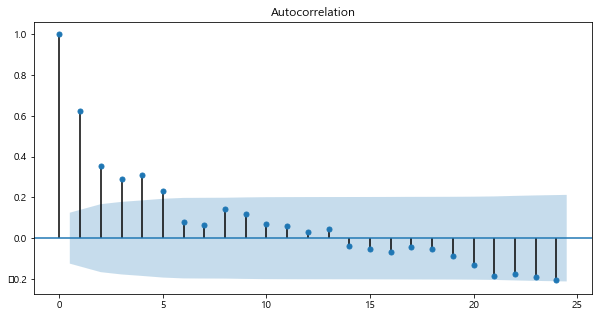

In [197]:
sm.graphics.tsa.plot_acf(result_mul_han.resid.dropna())
plt.show()

### 돼지 탕박에 관한 잔차 추출 

In [198]:
df = data[['주간날짜','돼지 탕박 경매 금액_주간평균']].set_index('주간날짜')

In [199]:
df['돼지 탕박 경매 금액_주간평균'].isnull().sum()

0

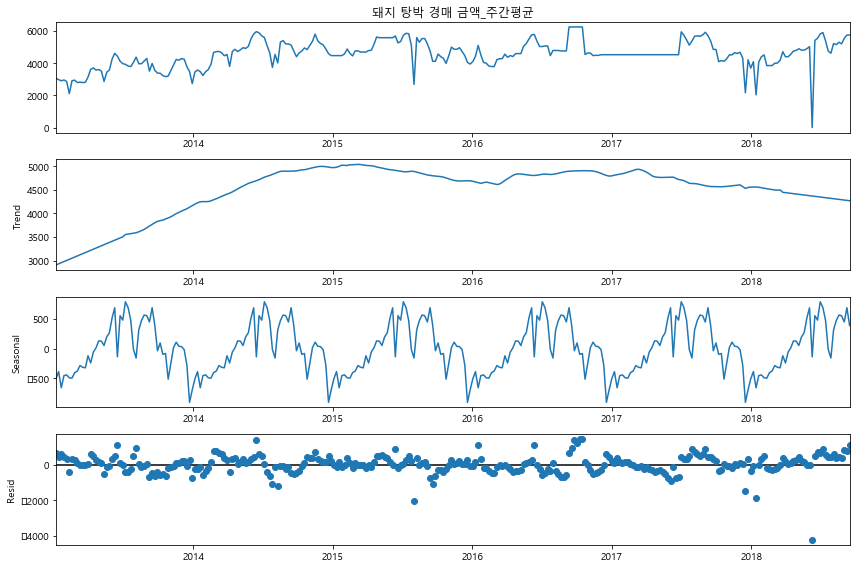

In [200]:
result_add_pig_52 = seasonal_decompose(df['돼지 탕박 경매 금액_주간평균'], model='additive',extrapolate_trend=52)

plt.rcParams['figure.figsize'] = [12, 8]

result_add_pig_52.plot()

plt.show()


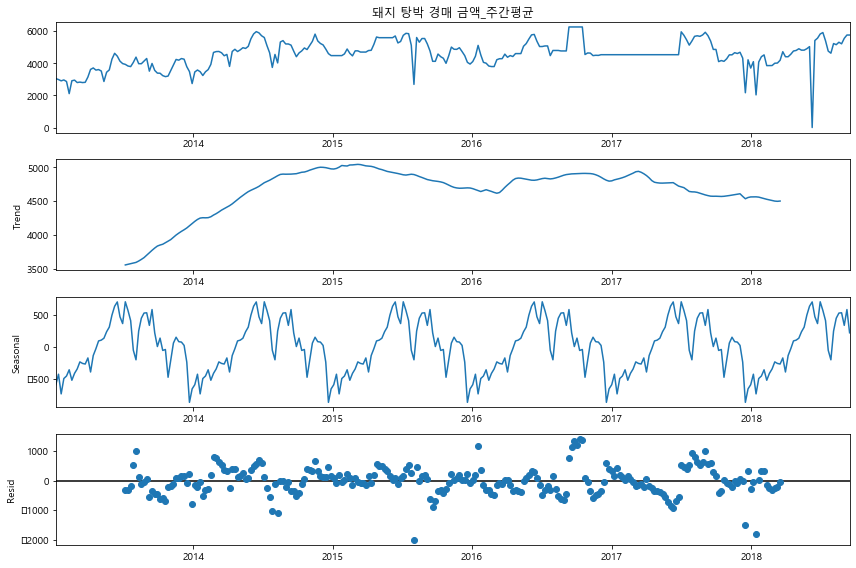

In [201]:
result_add_pig = seasonal_decompose(df['돼지 탕박 경매 금액_주간평균'], model='additive')

plt.rcParams['figure.figsize'] = [12, 8]

result_add_pig.plot()

plt.show()


In [239]:
'''
result_mul_pig = seasonal_decompose(df['돼지 탕박 경매 금액_주간평균'], model='multiple')

plt.rcParams['figure.figsize'] = [12, 8]

result_mul_pig.plot()

plt.show()

[error]
ValueError: Multiplicative seasonality is not appropriate for zero and negative values
'''

"\nresult_mul_pig = seasonal_decompose(df['돼지 탕박 경매 금액_주간평균'], model='multiple')\n\nplt.rcParams['figure.figsize'] = [12, 8]\n\nresult_mul_pig.plot()\n\nplt.show()\n\n[error]\nValueError: Multiplicative seasonality is not appropriate for zero and negative values\n"

#### kpss를 통해 잔차 검정

In [203]:
kpsstest = kpss(result_mul_han_52.resid.dropna(), regression='ct')
kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
kpss_output

Test Statistic     0.036133
p-value            0.100000
Lags Used         16.000000
dtype: float64

In [204]:
kpsstest = kpss(result_add_han_52.resid.dropna(), regression='ct')
kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
kpss_output

Test Statistic     0.039859
p-value            0.100000
Lags Used         16.000000
dtype: float64

---

### 잔차를 이용하여 파생 변수 생성

In [205]:
data = data2.copy()

In [206]:
data

,주간날짜,미국소_생산량(가격화한값),수출 (100만달러),수입 (100만달러),소비자물가지수 (2010=100),수입소고기_총량,평균기온,최저기온,최고기온,평균지면온도,최소상대습도(%),평균상대습도(%),한우 평균경매 금액_주간평균,돼지 탕박 경매 금액_주간평균,한우 경매 예상 두수_주간평균,명절유무,번식우,번식우_no
0,2013-01-06,226130.0,559632,515586,98,28623,-0.3,-4.6,5.4,-2.5,16.0,29.6,13875.600000,3044.800000,0.0,0,1580,916
1,2013-01-13,226130.0,559632,515586,98,28623,1.4,-2.2,6.1,0.0,30.0,49.6,13213.333333,2984.000000,0.0,0,1580,916
2,2013-01-20,226130.0,559632,515586,98,28623,1.5,-2.2,2.7,0.1,40.0,64.9,12588.833333,2904.000000,0.0,0,1580,916
3,2013-01-27,226130.0,559632,515586,98,28623,3.8,-0.9,9.3,0.4,40.0,63.0,12323.833333,2959.666667,0.0,1,1580,916
4,2013-02-03,187340.0,559632,515586,98,18241,1.5,-1.9,4.5,0.8,22.0,48.4,12325.166667,2862.833333,0.0,1,1580,916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,2018-08-19,242960.0,604860,535202,104,42590,25.1,21.3,27.9,26.2,54.0,72.4,16835.000000,5305.000000,108.5,0,1758,904
294,2018-08-26,242960.0,604860,535202,104,42590,23.2,20.9,27.2,24.5,54.0,77.4,17555.000000,5207.500000,250.0,0,1758,904
295,2018-09-02,215750.0,604860,535202,104,34151,22.4,19.6,25.9,24.4,40.0,60.1,18369.000000,5548.000000,443.0,0,1758,904
296,2018-09-09,215750.0,604860,535202,104,34151,19.4,16.0,23.3,22.1,62.0,77.3,18757.000000,5754.000000,449.0,1,1758,904


In [207]:
data['resid'] = pd.DataFrame(result_mul_han.resid).reset_index()['resid']
data['resid_week'] = pd.DataFrame(result_mul_han_52.resid).reset_index()['resid']   # 맨 마지막에 na발생 
data['pig_resid'] = pd.DataFrame(result_add_pig.resid).reset_index()['resid']
data['pig_resid_week'] = pd.DataFrame(result_add_pig_52.resid).reset_index()['resid']

In [208]:
data.isnull().sum()

주간날짜                   0
미국소_생산량(가격화한값)         0
수출 (100만달러)            0
수입 (100만달러)            0
소비자물가지수 (2010=100)     0
수입소고기_총량               0
평균기온                   0
최저기온                   0
최고기온                   0
평균지면온도                 0
최소상대습도(%)              0
평균상대습도(%)              0
한우 평균경매 금액_주간평균        0
돼지 탕박 경매 금액_주간평균       0
한우 경매 예상 두수_주간평균       0
명절유무                   0
번식우                    0
번식우_no                 0
resid                 52
resid_week             0
pig_resid             52
pig_resid_week         0
dtype: int64

In [209]:
data['resid'] = data['resid'].fillna(np.nanmean(data['resid']))
data['pig_resid'] = data['pig_resid'].fillna(np.nanmean(data['pig_resid']))

In [210]:
data['pig_resid'].isnull().sum()

0

In [211]:
data['resid'].isnull().sum()

0

In [212]:
data['resid'].dropna()

0      1.000863
1      1.000863
2      1.000863
3      1.000863
4      1.000863
         ...   
293    1.000863
294    1.000863
295    1.000863
296    1.000863
297    1.000863
Name: resid, Length: 298, dtype: float64

In [213]:
data['y_sd'] = ''
data['y_sd_week'] = ''
data['y_before'] = ''
data['y_before_week'] = ''
data['pig_resid_before'] = ''
data['pig_resid_before_week'] = ''

data = data.reset_index()

for i in range(1,len(data['resid'])):
    data['y_sd'][i] = data['resid'][i-1]-np.mean(data['resid'])
    data['y_sd_week'][i] = data['resid_week'][i-1]-np.mean(data['resid_week'])

    data['y_before'][i] = data['resid'][i-1]
    data['y_before_week'][i] = data['resid_week'][i-1]

    data['pig_resid_before'][i] = data['pig_resid'][i-1]
    data['pig_resid_before_week'][i] = data['pig_resid_week'][i-1]

In [214]:
data['y_sd'].value_counts()

1.9984014443252818e-15    51
-0.07595784983430798       1
0.03993019349732796        1
0.009547773252724934       1
0.02457956935463801        1
                          ..
0.03254740407736478        1
-0.013480010493783667      1
-0.013331676981577001      1
-0.016145572244237516      1
                           1
Name: y_sd, Length: 248, dtype: int64

In [215]:
y_series = data['한우 평균경매 금액_주간평균']
ma_y_list = []
for i in range(2,len(y_series)):
    
    ma_y = (y_series[i-2:i+3]).mean()
    ma_y_list.append(ma_y)
print(len(ma_y_list))

ma_y_list.insert(0, np.nan)
ma_y_list.insert(1, np.nan)
ma_y_list

data['cow_ma'] = np.array(ma_y_list)
data.head()

y_series = data['돼지 탕박 경매 금액_주간평균']
ma_y_list = []
for i in range(2,len(y_series)):
    
    ma_y = (y_series[i-2:i+3]).mean()
    ma_y_list.append(ma_y)
print(len(ma_y_list))

ma_y_list.insert(0, np.nan)
ma_y_list.insert(1, np.nan)
ma_y_list

data['pig_2_5_ma'] = np.array(ma_y_list)
data.head()

y_series = data['pig_resid']
ma_y_list = []
for i in range(2,len(y_series)):
    
    ma_y = (y_series[i-2:i+3]).mean()
    ma_y_list.append(ma_y)
print(len(ma_y_list))

ma_y_list.insert(0, np.nan)
ma_y_list.insert(1, np.nan)
ma_y_list

data['pig_resid_ma'] = np.array(ma_y_list)
data.head()


y_series = data['pig_resid_week']
ma_y_list = []
for i in range(2,len(y_series)):
    
    ma_y = (y_series[i-2:i+3]).mean()
    ma_y_list.append(ma_y)
print(len(ma_y_list))

ma_y_list.insert(0, np.nan)
ma_y_list.insert(1, np.nan)
ma_y_list

data['pig_resid_week_ma'] = np.array(ma_y_list)
data.head()

y_series = data['resid']
ma_y_list = []
for i in range(2,len(y_series)):
    
    ma_y = (y_series[i-2:i+3]).mean()
    ma_y_list.append(ma_y)
print(len(ma_y_list))

ma_y_list.insert(0, np.nan)
ma_y_list.insert(1, np.nan)
ma_y_list

data['cow_resid_ma'] = np.array(ma_y_list)
data.head()

y_series = data['resid_week']
ma_y_list = []
for i in range(2,len(y_series)):
    
    ma_y = (y_series[i-2:i+3]).mean()
    ma_y_list.append(ma_y)
print(len(ma_y_list))

ma_y_list.insert(0, np.nan)
ma_y_list.insert(1, np.nan)
ma_y_list

data['cow_resid_week_ma'] = np.array(ma_y_list)
data.head()


296
296
296
296
296
296


,index,주간날짜,미국소_생산량(가격화한값),수출 (100만달러),수입 (100만달러),소비자물가지수 (2010=100),수입소고기_총량,평균기온,최저기온,최고기온,...,y_before,y_before_week,pig_resid_before,pig_resid_before_week,cow_ma,pig_2_5_ma,pig_resid_ma,pig_resid_week_ma,cow_resid_ma,cow_resid_week_ma
0,0,2013-01-06,226130.0,559632,515586,98,28623,-0.3,-4.6,5.4,...,,,,,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2013-01-13,226130.0,559632,515586,98,28623,1.4,-2.2,6.1,...,1.00086,1.13712,-1.23935,644.681,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2013-01-20,226130.0,559632,515586,98,28623,1.5,-2.2,2.7,...,1.00086,1.10081,-1.23935,438.382,12865.353333,2951.06,-1.239351,485.054509,1.000863,1.092819
3,3,2013-01-27,226130.0,559632,515586,98,28623,3.8,-0.9,9.3,...,1.00086,1.06937,-1.23935,606.983,12592.283333,2763.90,-1.239351,270.575887,1.000863,1.076192
4,4,2013-02-03,187340.0,559632,515586,98,18241,1.5,-1.9,4.5,...,1.00086,1.06976,-1.23935,434.21,12341.176667,2748.70,-1.239351,253.685059,1.000863,1.062161


In [216]:
del data['index']

In [217]:
data.tail()

,주간날짜,미국소_생산량(가격화한값),수출 (100만달러),수입 (100만달러),소비자물가지수 (2010=100),수입소고기_총량,평균기온,최저기온,최고기온,평균지면온도,...,y_before,y_before_week,pig_resid_before,pig_resid_before_week,cow_ma,pig_2_5_ma,pig_resid_ma,pig_resid_week_ma,cow_resid_ma,cow_resid_week_ma
293,2018-08-19,242960.0,604860,535202,104,42590,25.1,21.3,27.9,26.2,...,1.00086,1.02317,-1.23935,374.256,17829.800000,5287.500000,-1.239351,516.062830,1.000863,0.997980
294,2018-08-26,242960.0,604860,535202,104,42590,23.2,20.9,27.2,24.5,...,1.00086,0.964366,-1.23935,439.32,17970.400000,5393.700000,-1.239351,554.668958,1.000863,0.999253
295,2018-09-02,215750.0,604860,535202,104,34151,22.4,19.6,25.9,24.4,...,1.00086,0.979869,-1.23935,360.441,18054.600000,5513.700000,-1.239351,698.533985,1.000863,1.003676
296,2018-09-09,215750.0,604860,535202,104,34151,19.4,16.0,23.3,22.1,...,1.00086,1.00475,-1.23935,813.346,18359.500000,5565.875000,-1.239351,763.337379,1.000863,1.013503
297,2018-09-16,215750.0,604860,535202,104,34151,21.1,17.2,24.8,22.4,...,1.00086,1.02411,-1.23935,785.981,18627.666667,5685.333333,-1.239351,897.636090,1.000863,1.024715


In [218]:
data = data.iloc[1:,:]

In [219]:
data = data.reset_index()
del data['index']

In [220]:
data['cow_resid_diff'] = ''
data['cow_resid_diff_week'] = ''

for i in range(1,len(data['y_before'])):
    data['cow_resid_diff'][i] = data['y_before'][i]-data['y_before'][i-1]
    data['cow_resid_diff_week'][i] =data['y_before_week'][i]-data['y_before_week'][i-1]

In [221]:
data.isnull().sum()

주간날짜                     0
미국소_생산량(가격화한값)           0
수출 (100만달러)              0
수입 (100만달러)              0
소비자물가지수 (2010=100)       0
수입소고기_총량                 0
평균기온                     0
최저기온                     0
최고기온                     0
평균지면온도                   0
최소상대습도(%)                0
평균상대습도(%)                0
한우 평균경매 금액_주간평균          0
돼지 탕박 경매 금액_주간평균         0
한우 경매 예상 두수_주간평균         0
명절유무                     0
번식우                      0
번식우_no                   0
resid                    0
resid_week               0
pig_resid                0
pig_resid_week           0
y_sd                     0
y_sd_week                0
y_before                 0
y_before_week            0
pig_resid_before         0
pig_resid_before_week    0
cow_ma                   1
pig_2_5_ma               1
pig_resid_ma             1
pig_resid_week_ma        1
cow_resid_ma             1
cow_resid_week_ma        1
cow_resid_diff           0
cow_resid_diff_week      0
dtype: int64

###  소 개체 수 관련 파생 변수 데이터 불러오기 

In [222]:
hun = pd.read_pickle('huns_final_data.pkl')

In [223]:
hun

,주간날짜,미국소_생산량(가격화한값),한우 평균경매 금액_주간평균,돼지 탕박 경매 금액_주간평균,수출 (100만달러),수입 (100만달러),소비자물가지수 (2010=100),수입소고기_총량,평균기온,최저기온,...,평균상대습도(%),번식우,번식우_no,y_sd,y_before,pig_resid_before,cow_resid_ma,cow_resid_diff,breed_cow_sd,no_breed_cow_sd
0,2013-01-13,226130.0,13213.33,2984.00,559632,515586,98,28623,1.4,-2.2,...,49.6,1580,916,,,,1.001153,0.0,12.851852,-58.148148
1,2013-01-20,226130.0,12588.83,2904.00,559632,515586,98,28623,1.5,-2.2,...,64.9,1580,916,2.22045e-16,1.00115,1.00115,1.001153,0.0,12.851852,-58.148148
2,2013-01-27,226130.0,12323.83,2959.67,559632,515586,98,28623,3.8,-0.9,...,63.0,1580,916,2.22045e-16,1.00115,1.00115,1.001153,0.0,12.851852,-58.148148
3,2013-02-03,187340.0,12325.17,2862.83,559632,515586,98,18241,1.5,-1.9,...,48.4,1580,916,2.22045e-16,1.00115,1.00115,1.001153,0.0,12.851852,-58.148148
4,2013-02-10,187340.0,12510.25,2109.00,559632,515586,98,18241,0.5,-3.8,...,37.3,1580,916,2.22045e-16,1.00115,1.00115,1.001153,0.0,12.851852,-58.148148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,2018-08-19,242960.0,16835.00,5305.00,604860,535202,104,42590,25.1,21.3,...,72.4,1758,904,2.22045e-16,1.00115,1.00115,1.001153,0.0,190.851852,-70.148148
293,2018-08-26,242960.0,17555.00,5207.50,604860,535202,104,42590,23.2,20.9,...,77.4,1758,904,2.22045e-16,1.00115,1.00115,1.001153,0.0,190.851852,-70.148148
294,2018-09-02,215750.0,18369.00,5548.00,604860,535202,104,34151,22.4,19.6,...,60.1,1758,904,2.22045e-16,1.00115,1.00115,1.001153,0.0,190.851852,-70.148148
295,2018-09-09,215750.0,18757.00,5754.00,604860,535202,104,34151,19.4,16.0,...,77.3,1758,904,2.22045e-16,1.00115,1.00115,1.001153,0.0,190.851852,-70.148148


In [224]:
data

,주간날짜,미국소_생산량(가격화한값),수출 (100만달러),수입 (100만달러),소비자물가지수 (2010=100),수입소고기_총량,평균기온,최저기온,최고기온,평균지면온도,...,pig_resid_before,pig_resid_before_week,cow_ma,pig_2_5_ma,pig_resid_ma,pig_resid_week_ma,cow_resid_ma,cow_resid_week_ma,cow_resid_diff,cow_resid_diff_week
0,2013-01-13,226130.0,559632,515586,98,28623,1.4,-2.2,6.1,0.0,...,-1.23935,644.681,NaN,NaN,NaN,NaN,NaN,NaN,,
1,2013-01-20,226130.0,559632,515586,98,28623,1.5,-2.2,2.7,0.1,...,-1.23935,438.382,12865.353333,2951.060000,-1.239351,485.054509,1.000863,1.092819,0,-0.0363163
2,2013-01-27,226130.0,559632,515586,98,28623,3.8,-0.9,9.3,0.4,...,-1.23935,606.983,12592.283333,2763.900000,-1.239351,270.575887,1.000863,1.076192,0,-0.0314346
3,2013-02-03,187340.0,559632,515586,98,18241,1.5,-1.9,4.5,0.8,...,-1.23935,434.21,12341.176667,2748.700000,-1.239351,253.685059,1.000863,1.062161,0,0.000384575
4,2013-02-10,187340.0,559632,515586,98,18241,0.5,-3.8,4.9,0.4,...,-1.23935,301.017,12162.910000,2757.700000,-1.239351,188.051875,1.000863,1.050355,0,0.0172806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,2018-08-19,242960.0,604860,535202,104,42590,25.1,21.3,27.9,26.2,...,-1.23935,374.256,17829.800000,5287.500000,-1.239351,516.062830,1.000863,0.997980,0,0.0054191
293,2018-08-26,242960.0,604860,535202,104,42590,23.2,20.9,27.2,24.5,...,-1.23935,439.32,17970.400000,5393.700000,-1.239351,554.668958,1.000863,0.999253,0,-0.058802
294,2018-09-02,215750.0,604860,535202,104,34151,22.4,19.6,25.9,24.4,...,-1.23935,360.441,18054.600000,5513.700000,-1.239351,698.533985,1.000863,1.003676,0,0.0155031
295,2018-09-09,215750.0,604860,535202,104,34151,19.4,16.0,23.3,22.1,...,-1.23935,813.346,18359.500000,5565.875000,-1.239351,763.337379,1.000863,1.013503,0,0.0248786


In [225]:
data2 = pd.merge(hun[['주간날짜','breed_cow_sd','no_breed_cow_sd']],data, on='주간날짜', how='inner')

In [226]:
data2

,주간날짜,breed_cow_sd,no_breed_cow_sd,미국소_생산량(가격화한값),수출 (100만달러),수입 (100만달러),소비자물가지수 (2010=100),수입소고기_총량,평균기온,최저기온,...,pig_resid_before,pig_resid_before_week,cow_ma,pig_2_5_ma,pig_resid_ma,pig_resid_week_ma,cow_resid_ma,cow_resid_week_ma,cow_resid_diff,cow_resid_diff_week
0,2013-01-13,12.851852,-58.148148,226130.0,559632,515586,98,28623,1.4,-2.2,...,-1.23935,644.681,NaN,NaN,NaN,NaN,NaN,NaN,,
1,2013-01-20,12.851852,-58.148148,226130.0,559632,515586,98,28623,1.5,-2.2,...,-1.23935,438.382,12865.353333,2951.060000,-1.239351,485.054509,1.000863,1.092819,0,-0.0363163
2,2013-01-27,12.851852,-58.148148,226130.0,559632,515586,98,28623,3.8,-0.9,...,-1.23935,606.983,12592.283333,2763.900000,-1.239351,270.575887,1.000863,1.076192,0,-0.0314346
3,2013-02-03,12.851852,-58.148148,187340.0,559632,515586,98,18241,1.5,-1.9,...,-1.23935,434.21,12341.176667,2748.700000,-1.239351,253.685059,1.000863,1.062161,0,0.000384575
4,2013-02-10,12.851852,-58.148148,187340.0,559632,515586,98,18241,0.5,-3.8,...,-1.23935,301.017,12162.910000,2757.700000,-1.239351,188.051875,1.000863,1.050355,0,0.0172806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,2018-08-19,190.851852,-70.148148,242960.0,604860,535202,104,42590,25.1,21.3,...,-1.23935,374.256,17829.800000,5287.500000,-1.239351,516.062830,1.000863,0.997980,0,0.0054191
293,2018-08-26,190.851852,-70.148148,242960.0,604860,535202,104,42590,23.2,20.9,...,-1.23935,439.32,17970.400000,5393.700000,-1.239351,554.668958,1.000863,0.999253,0,-0.058802
294,2018-09-02,190.851852,-70.148148,215750.0,604860,535202,104,34151,22.4,19.6,...,-1.23935,360.441,18054.600000,5513.700000,-1.239351,698.533985,1.000863,1.003676,0,0.0155031
295,2018-09-09,190.851852,-70.148148,215750.0,604860,535202,104,34151,19.4,16.0,...,-1.23935,813.346,18359.500000,5565.875000,-1.239351,763.337379,1.000863,1.013503,0,0.0248786


In [227]:
data2.columns

Index(['주간날짜', 'breed_cow_sd', 'no_breed_cow_sd', '미국소_생산량(가격화한값)',
       '수출 (100만달러)', '수입 (100만달러)', '소비자물가지수 (2010=100)', '수입소고기_총량', '평균기온',
       '최저기온', '최고기온', '평균지면온도', '최소상대습도(%)', '평균상대습도(%)', '한우 평균경매 금액_주간평균',
       '돼지 탕박 경매 금액_주간평균', '한우 경매 예상 두수_주간평균', '명절유무', '번식우', '번식우_no',
       'resid', 'resid_week', 'pig_resid', 'pig_resid_week', 'y_sd',
       'y_sd_week', 'y_before', 'y_before_week', 'pig_resid_before',
       'pig_resid_before_week', 'cow_ma', 'pig_2_5_ma', 'pig_resid_ma',
       'pig_resid_week_ma', 'cow_resid_ma', 'cow_resid_week_ma',
       'cow_resid_diff', 'cow_resid_diff_week'],
      dtype='object')

In [228]:
# 변수명 추출
data_names = data2.drop(['cow_resid_week_ma','cow_resid_diff_week','pig_resid_week_ma','pig_resid_before_week','y_before_week','y_sd_week','pig_resid_week','resid_week'],axis=1).columns
data_names = [list(i) for i in data_names]
features_origin = [''.join(i) for i in data_names]
features_origin

['주간날짜',
 'breed_cow_sd',
 'no_breed_cow_sd',
 '미국소_생산량(가격화한값)',
 '수출 (100만달러)',
 '수입 (100만달러)',
 '소비자물가지수 (2010=100)',
 '수입소고기_총량',
 '평균기온',
 '최저기온',
 '최고기온',
 '평균지면온도',
 '최소상대습도(%)',
 '평균상대습도(%)',
 '한우 평균경매 금액_주간평균',
 '돼지 탕박 경매 금액_주간평균',
 '한우 경매 예상 두수_주간평균',
 '명절유무',
 '번식우',
 '번식우_no',
 'resid',
 'pig_resid',
 'y_sd',
 'y_before',
 'pig_resid_before',
 'cow_ma',
 'pig_2_5_ma',
 'pig_resid_ma',
 'cow_resid_ma',
 'cow_resid_diff']

In [229]:
data2[features_origin].shape

(297, 30)

In [230]:
data2[features_origin].to_pickle('data_origin.pkl')

In [231]:
data2.columns

Index(['주간날짜', 'breed_cow_sd', 'no_breed_cow_sd', '미국소_생산량(가격화한값)',
       '수출 (100만달러)', '수입 (100만달러)', '소비자물가지수 (2010=100)', '수입소고기_총량', '평균기온',
       '최저기온', '최고기온', '평균지면온도', '최소상대습도(%)', '평균상대습도(%)', '한우 평균경매 금액_주간평균',
       '돼지 탕박 경매 금액_주간평균', '한우 경매 예상 두수_주간평균', '명절유무', '번식우', '번식우_no',
       'resid', 'resid_week', 'pig_resid', 'pig_resid_week', 'y_sd',
       'y_sd_week', 'y_before', 'y_before_week', 'pig_resid_before',
       'pig_resid_before_week', 'cow_ma', 'pig_2_5_ma', 'pig_resid_ma',
       'pig_resid_week_ma', 'cow_resid_ma', 'cow_resid_week_ma',
       'cow_resid_diff', 'cow_resid_diff_week'],
      dtype='object')

In [232]:
data2[features].shape

(297, 18)

In [233]:
# 변수명 추출
data_names = data2.drop(['cow_resid_ma','cow_resid_diff','pig_resid_ma','pig_resid_before','y_before','y_sd','pig_resid','resid'],axis=1).columns
data_names = [list(i) for i in data_names]
features_week = [''.join(i) for i in data_names]
features_week

['주간날짜',
 'breed_cow_sd',
 'no_breed_cow_sd',
 '미국소_생산량(가격화한값)',
 '수출 (100만달러)',
 '수입 (100만달러)',
 '소비자물가지수 (2010=100)',
 '수입소고기_총량',
 '평균기온',
 '최저기온',
 '최고기온',
 '평균지면온도',
 '최소상대습도(%)',
 '평균상대습도(%)',
 '한우 평균경매 금액_주간평균',
 '돼지 탕박 경매 금액_주간평균',
 '한우 경매 예상 두수_주간평균',
 '명절유무',
 '번식우',
 '번식우_no',
 'resid_week',
 'pig_resid_week',
 'y_sd_week',
 'y_before_week',
 'pig_resid_before_week',
 'cow_ma',
 'pig_2_5_ma',
 'pig_resid_week_ma',
 'cow_resid_week_ma',
 'cow_resid_diff_week']

In [234]:
data_week = data2[features_week]
data_week.shape

(297, 30)

In [235]:
data_week.to_pickle('data_week.pkl')

---

### data_week 데이터에 이상치 제거 파생변수 추가
* y값의 잔차(Feature 이름: resid)에 대한 이창시 제거 파생변수
 
    - median_filter 함수 적용해 window_size=3일 때 파생변수 추가
    - median_filter 함수 적용해 window_size=5일 때 파생변수 추가
    - hampel 함수 적용해 파생변수 추가

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid',
       font='Malgun Gothic',
       rc={'axes.unicode_minus':False})

In [8]:
import pickle
fold_dir = 'C:/Users/joyh1/Desktop/DSC/DSC_음메/cow_data/final_data/'
data_week = pd.read_pickle(fold_dir+'data_week.pkl')

print(data_week.shape)

(297, 28)


#### median filter(window_size=3, 5일 때) 적용해 파생변수 생성

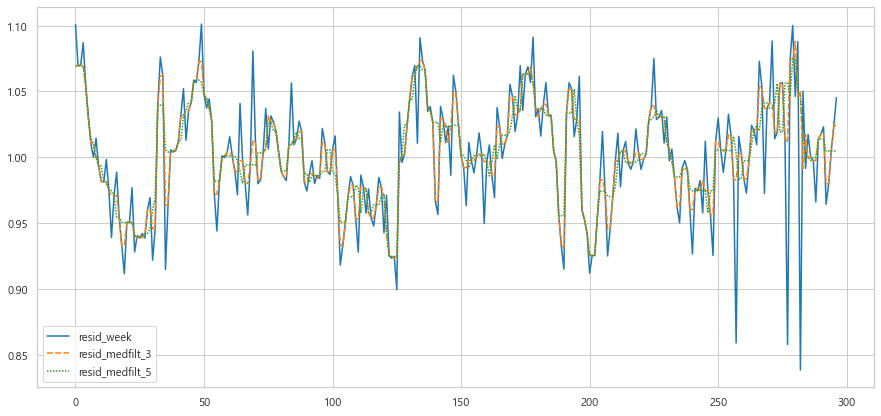

In [10]:
from scipy.signal import medfilt
data_week['resid_medfilt_3'] = medfilt(data_week['resid_week'], kernel_size=3)
data_week['resid_medfilt_5'] = medfilt(data_week['resid_week'], kernel_size=5)

# median_filter 시각화
df = data_week[['resid_week','resid_medfilt_3','resid_medfilt_5']]

plt.figure(figsize=(15,7))
sns.lineplot(data=df, palette='tab10')

#### hampel 함수 적용해 파생변수 생성
    - hampel 함수는 Python으로 만든 오픈소스 hampel 함수 사용

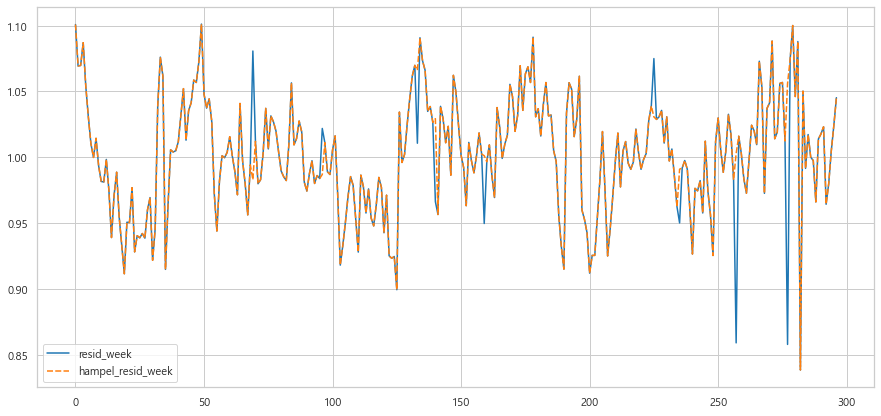

In [12]:
data_week['hampel_resid_week'] = hampel(data_week['resid_week'], 3)
# thresohld=4일때 
plt.figure(figsize=(15,7))
sns.lineplot(data=data_week[['resid_week','hampel_resid_week']], palette='tab10')

In [11]:
##### hampel 함수 #####

#python
# 1D hampel filter
# 
# purpose
#  Outlier detection and remove

def hampel(x,k,method="center",thr=4):
    #Input
    # x       input data
    # k       half window size (full 2*k+1)
    # mode    about both ends
    #         str {‘center’, 'same','ignore',‘nan’}, optional
    #
    #           center  set center of window at target value
    #           same    always same window size
    #           ignore  set original data
    #           nan     set non
    #           
    # thr     threshold (defaut 3), optional
    #Output
    # newX    filtered data
    # omadIdx indices of outliers
    arraySize=len(x)
    idx=np.arange(arraySize)
    newX=x.copy()
    omadIdx=np.zeros_like(x)
    for i in range(arraySize):
        mask1=np.where( idx>= (idx[i]-k) ,True, False)
        mask2=np.where( idx<= (idx[i]+k) ,True, False)
        kernel= np.logical_and(mask1,mask2)
        if method=="same":
            if i<(k):
                kernel=np.zeros_like(x).astype(bool)
                kernel[:(2*k+1)]=True
            elif i>= (len(x)-k):
                kernel=np.zeros_like(x).astype(bool)
                kernel[-(2*k+1):]=True
        #print (kernel.astype(int))
        #print (x[kernel])
        med0=np.median(x[kernel])
        #print (med0)
        s0=1.4826*np.median(np.abs(x[kernel]-med0))
        if np.abs(x[i]-med0)>thr*s0:
             omadIdx[i]=1
             newX[i]=med0
    
    if method=="nan":
        newX[:k]=np.nan
        newX[-k:]=np.nan
        omadIdx[:k]=0
        omadIdx[-k:]=0
    elif method=="ignore":
        newX[:k]=x[:k]
        newX[-k:]=x[-k:]
        omadIdx[:k]=0
        omadIdx[-k:]=0        
        
    return newX

In [13]:
data_week.columns

Index(['주간날짜', 'breed_cow_sd', 'no_breed_cow_sd', '미국소_생산량(가격화한값)',
       '수출 (100만달러)', '수입 (100만달러)', '소비자물가지수 (2010=100)', '수입소고기_총량', '평균기온',
       '최저기온', '최고기온', '평균지면온도', '최소상대습도(%)', '평균상대습도(%)', '한우 평균경매 금액_주간평균',
       '돼지 탕박 경매 금액_주간평균', '한우 경매 예상 두수_주간평균', '명절유무', 'resid_week',
       'pig_resid_week', 'y_sd_week', 'y_before_week', 'pig_resid_before_week',
       'cow_ma', 'pig_2_5_ma', 'pig_resid_week_ma', 'cow_resid_week_ma',
       'cow_resid_diff_week', 'resid_medfilt_3', 'resid_medfilt_5',
       'hampel_resid_week'],
      dtype='object')

### 최종 데이터 pickle파일로 저장

In [14]:
with open('data_week_real_final', 'wb') as f:
    pickle.dump(data_week, f)